# Module 3B Stream B: Explainable AI Techniques

Machine Learning / Deep Learning approaches, such as Neural Networks, are one of the most powerful suporvised techniques in computer science. They were able to contribute to powerful spam filters, image recognition, medical diagnosis, market estimation, etc, that have very high predictive scores.

Despite the rapid advances in machine intelligence, its adoption by human users is impeded by a lack of **trust** in the accuracy of the results generated by the predictive models. Consequently, it is hard for users to gain insights regarding the underlying reasons that have led to certain predictions. 

Without understanding the rationale of the black-box machinery, there will be a lack of trust in the accuracy of the predictions, thus a reluctance to use the predictions, and in the worse case, consequences of an incorrect decision based on the predictions. Moreover, the consequences of misclassifications, either due to biases in data, or simply because the algorithm could not generalise well enough, can be damaging for decision-makers and can put certain societal groups at risk. This is what it is known as the **black box problem**.

<img src="images/black_box.png" />


In this lectture, we will be looking at state of the art techniques that try to address the black box problem. Notice that these techniques are not perfect and interpretability and explainability of predictive black boxes is still an open research question and a very hot topic in the litearture.

The algorithm that we will be looking at is LIME (Local Interpretable Model-Agnostic Explanations).


## What is LIME?

LIME (Local Interpretable Model-agnostic Explanations)is a novel explanation technique that explains the prediction of any classifier in an interpretable and faithful manner by learning a interpretable model locally around the prediction.

It works with **ANY CLASSIFIER** and explains a prediction so that even the non experts could compare and improve on an untrustworthy model.

## What is an Explanation?

Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation. The figure below illustrates the intuition for this procedure. The model's decision function is represented by the blue/pink background, and is clearly nonlinear. The bright red cross is the instance being explained (let's call it X). We sample instances around X, and weight them according to their proximity to X (weight here is indicated by size). We then learn a linear model (dashed line) that approximates the model well in the vicinity of X, but not necessarily globally.

<img src="https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png" />


Source <a href="https://github.com/marcotcr/lime">LIME</a>

In [ ]:
# scatter plot of the circles dataset with points colored by class
from sklearn.datasets import make_circles
from numpy import where
from matplotlib import pyplot

# mlp for the two circles classification problem
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Flatten, Conv2D, MaxPool2D,  Conv3D, MaxPool3D,Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import RandomUniform

# keras / deep learning libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

# callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Figure Plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import seaborn as sns
sns.set()

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import statistics as stat

# very important for feature transformation
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler,LabelEncoder

import warnings
warnings.filterwarnings("ignore")


from tensorflow.keras import metrics
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.initializers import glorot_uniform

import lime


## Explaining the Breast Cancer Dataset



In workshop 2B, you had to classify a breast tumour dataset using Naive Bayes algorithm. In this task, you will do classify again the dataset, but using:

- (1) a neural network with the 'tanh' as the activation function (you can choose as many hidden layers as you want)
- (2) a deep neural network with the 'relu' activation function (you can choose as many hidden layers as you want)

In [ ]:
# Let's revisit the breast cancer dataset

file_path = 'data/breast_data_full.csv'
data = pd.read_csv( file_path )
data

In [ ]:
class_var = "diagnosis"
feature_names = data.columns.to_list()
feature_names.remove(class_var)

X = data[feature_names]
y = data[class_var]

# general info about number of features and classes
n_features = X.shape[1]
n_samples = X.shape[0]
n_classes = len(data[class_var].unique())

In [ ]:
# normalize features
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

In [ ]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:

# separate the dataset into test set, validation set and train set
# YOUR CODE HERE:
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3 )
# create the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state = 515)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state = 515)

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
callbacks_list = [early_stop]

# define the Machine Learning Model: Neural Network
# YOUR CODE HERE:
model_tum = Sequential()

# add the required layers
# YOUR CODE HERE:
model_tum.add(Dense(10, input_dim= len(feature_names), activation='tanh'))
model_tum.add(Dropout(0.2))
model_tum.add(Dense(7, activation='tanh'))
model_tum.add(Dropout(0.2))
model_tum.add(Dense(3, activation='tanh'))
model_tum.add(Dropout(0.2))
model_tum.add(Dense(2, activation='sigmoid'))

# compile the network using: 
# the 'mean_squared_error' as a loss function
# the stochastic gradient descent ('sgd') as the optimization function
# and the 'accuracy' as evaluation metric
# YOUR CODE HERE:
model_tum.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# fit the model to the data -> learning the model
# YOUR CODE HERE:
# fit model
history = model_tum.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, verbose=0,  callbacks = callbacks_list)


In [274]:
# evaluate the model
# evaluate the model
train_loss, train_acc = model_tum.evaluate(X_train, y_train, verbose=1)
test_loss, test_acc = model_tum.evaluate(X_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

85/85 [==============================] - 0s 47us/sample - loss: 0.0973 - accuracy: 0.9765
Train: 0.987, Test: 0.976
Train: 0.059, Test: 0.097


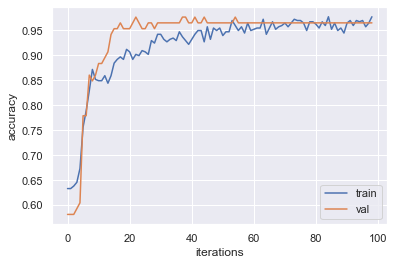

In [275]:
# plot training history
metric = "accuracy"
pyplot.plot(history.history[metric], label='train')
pyplot.plot(history.history["val_" + metric], label='val')
pyplot.ylabel('accuracy', fontsize=12)
pyplot.xlabel('iterations', fontsize=12)
pyplot.legend()
pyplot.show()

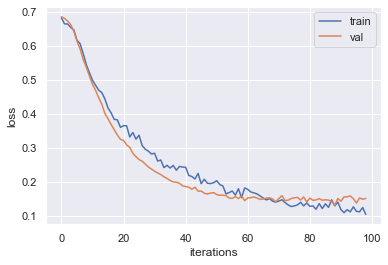

In [276]:
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.ylabel('loss', fontsize=12)
pyplot.xlabel('iterations', fontsize=12)
pyplot.legend()
pyplot.show()

## Explaining Predictions using LIME (Local interpretable model-agnostic explanations)

In [277]:
# let's pic up a specific patient:

# patient ID 0 predicted Cancer. True value Cancer
# patient ID 40 predicted No Cancer, true value Cancer
# patient ID 20 predicted No Cancer. True value No Cancer
# patient ID 541 predicted Cancer. true value No Cancer

patient_indx = 541
patients_feat = X_scaled[patient_indx,:]
patients_true_pred = enc.inverse_transform(np.expand_dims(Y[patient_indx,:], 0))[0][0]

# prediction
pred = model_tum.predict(np.expand_dims(patients_feat, 0))
pred = enc.inverse_transform( pred )[0][0]


print("Patient id: %d \t Predicted: %s \t True Diagnosis: %s\n" 
      %(patient_indx, "Cancer" if pred else "No Cancer", "Cancer" if patients_true_pred else "No Cancer"))


Patient id: 541 	 Predicted: No Cancer 	 True Diagnosis: No Cancer



### Why is the algorithm making these predictions?


In [ ]:
#!pip install lime

In [ ]:
import lime
from lime import lime_tabular


# lime also works text data
# lime also works image data

In [ ]:
feature_names = data.columns.to_list()
feature_names.remove(class_var)


In [ ]:
len(feature_names)

In [ ]:
# LIME has one explainer for all the models
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names= feature_names, 
                                                  class_names=["No Cancer", "Cancer"], verbose=False, mode='classification')


#### Explain Patient #0 (True Positive)

In [240]:
MAX_FEAT = 6

In [249]:
# make sure that the prediction of the model comes in probabilities
# model.predict_proba

patient_indx = 0
patients_feat = X_scaled[patient_indx,:]
exp = explainer.explain_instance(patients_feat, model_tum.predict_proba, num_features= MAX_FEAT )

In [250]:
# Show the predictions
exp.show_in_notebook(show_table=True )

In [243]:
exp.as_list()

[('concavity_mean > 0.31', 0.2387066806632327),
 ('concave points_mean > 0.37', 0.23004307138776392),
 ('area_worst > 0.23', 0.20380978474518158),
 ('radius_se > 0.13', 0.12717730882536954),
 ('area_se > 0.07', 0.1242148637164705),
 ('concavity_worst > 0.30', 0.11292141763019484)]

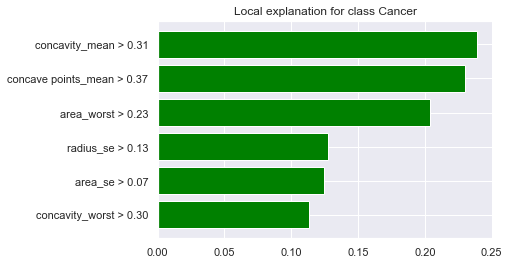

In [248]:
explanation_plot = exp.as_pyplot_figure()

#### Discussion: Do these results support a True Positive prediction?

**Answer here**

#### Explain Patient #40 (False Positive)


In [252]:
patient_indx = 40
patients_feat = X_scaled[patient_indx,:]
exp = explainer.explain_instance(patients_feat, model_tum.predict_proba, num_features=6 )

In [257]:
patients_feat

array([0.00092888, 0.3056936 , 0.40142036, 0.29293069, 0.17794274,
       0.26171346, 0.12554445, 0.07286785, 0.10094433, 0.36565657,
       0.12447346, 0.0459895 , 0.10305428, 0.03840173, 0.02564074,
       0.05326852, 0.06585153, 0.03510101, 0.13034666, 0.08327236,
       0.01351519, 0.28459623, 0.4858742 , 0.25942527, 0.14812721,
       0.25245988, 0.17173599, 0.16653355, 0.38213058, 0.28168736,
       0.10770038])

In [253]:
# Show the predictions
exp.show_in_notebook(show_table=True )

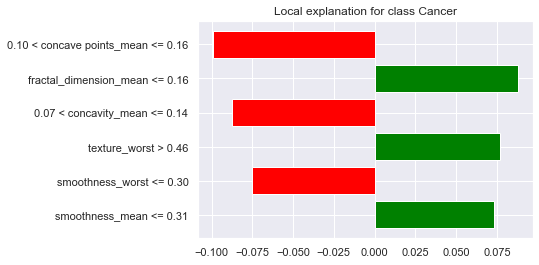

In [254]:
explanation_plot = exp.as_pyplot_figure()

In [261]:
model_tum.predict(np.expand_dims(patients_feat, 0)) 

array([[0.5672357 , 0.02231031]], dtype=float32)

#### Discussion: Do these results support a False Negative prediction?

**Answer here**

#### Explain Patient #20 (True Negative)

In [262]:
patient_indx = 20
patients_feat = X_scaled[patient_indx,:]
exp = explainer.explain_instance(patients_feat, model_tum.predict_proba, num_features=6 )

In [263]:
# Show the predictions
exp.show_in_notebook(show_table=True )

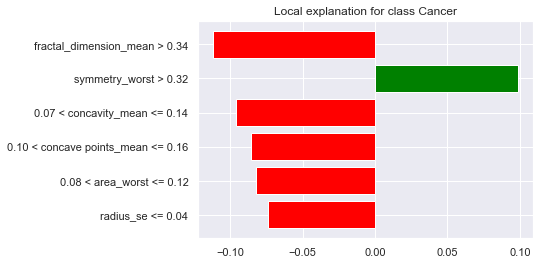

In [265]:
explanation_plot = exp.as_pyplot_figure()

#### Discussion: Do these results support a True Negative prediction?

**Answer here**

#### Explain Patient #541 (False Positive)

In [271]:
patient_indx = 541
patients_feat = X_scaled[patient_indx,:]
exp = explainer.explain_instance(patients_feat, model_tum.predict_proba, num_features=15 )


In [272]:
# Show the predictions
exp.show_in_notebook(show_table=True )

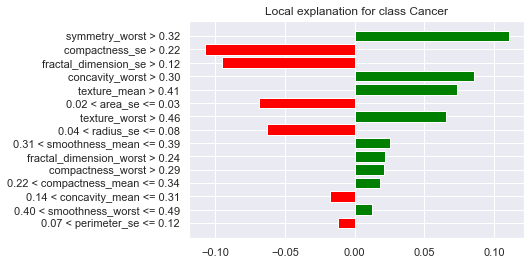

In [273]:
explanation_plot = exp.as_pyplot_figure()

#### Discussion: Do these results support a False Positive prediction?

**Answer here**

## Explaining the Manipulated Criminal Image Dataset

In [278]:
faces_dataset = pd.read_csv('data/dataset_64_v2.csv', delimiter=',')
faces_dataset

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0         253      253      253      253      253      253      253      253   
1          89       66       21       16       19       35       47       47   
2         237      236      238      239      239      241      241      237   
3         218      210      201      207      202      181      172      193   
4         143      155      182      187      182      166      113       64   
...       ...      ...      ...      ...      ...      ...      ...      ...   
2137      191      190      189      185      167       68       30       22   
2138       19       18       16        8        4        3        2        9   
2139       34       45       38       55       75       87       82       80   
2140        4        4        1       14        8        4        7       15   
2141       56       19       21       23       20       10       13       10   

      pixel_8  pixel_9  ...  pixel_4087  pixel_4088  pixel_4089  pixel_4090  \
0         253      253  ...          25          39          40          39   
1          41       36  ...         188         187         155         129   
2         222      193  ...          30          30          31          29   
3         195      201  ...           1           1           1           1   
4          55       59  ...          42          56          63          59   
...       ...      ...  ...         ...         ...         ...         ...   
2137       32       33  ...         208         198         199         189   
2138       12       13  ...          13          14          14          14   
2139       81       89  ...          32          35          37          38   
2140       12        7  ...         180         189         192         193   
2141       16       15  ...          56          41          33          63   

      pixel_4091  pixel_4092  pixel_4093  pixel_4094  pixel_4095  target  
0             42           0           0           0           0       1  
1            163         177         171         169         162       0  
2             33           0           0           0           0       1  
3              1           1           1           1           1       0  
4             60           0           0           0           0       1  
...          ...         ...         ...         ...         ...     ...  
2137         174         171         166         163         155       0  
2138          14           0           0           0           0       1  
2139          38          37          36          41          66       0  
2140         191         188         184         177          84       0  
2141         108         119         124         123         120       0  

[2142 rows x 4097 columns]

In [279]:
# total number of images in dataset:
num_images = len(faces_dataset)
num_pixels = len(faces_dataset.columns) - 1

print('Total number of images in the dataset is: ' + str(num_images))
print('Total number of pixels per image is: ' + str(num_pixels))

Total number of images in the dataset is: 2142
Total number of pixels per image is: 4096


In [280]:
# We can also try to understand what is the distribution of criminals / not crimials in our dataset:
criminals = faces_dataset[ faces_dataset['target'] == 1 ]
not_criminals = faces_dataset[ faces_dataset['target'] == 0 ]

print('Criminality distribution:')
print('Number of criminals: ' + str(len(criminals)))
print('Number of not criminals: ' + str(len(not_criminals)))

Criminality distribution:
Number of criminals: 1049
Number of not criminals: 1093


Image label = CRIMINAL


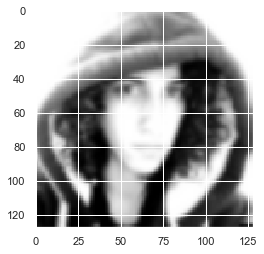

In [281]:
# getting some images... 
from skimage.transform import resize

indx = 0
image_0 = faces_dataset.iloc[indx,0:num_pixels]

# image_0 is a vector with 9216 pixels. In order to convert it into an image,
# we need to reshape this vector into a matrix of 96*96 = 9216 pixels

image_0 =  np.array(image_0)
image_0 = np.reshape(image_0, (64, 64))
image_0 = resize(image_0, (128, 128), anti_aliasing=True)

# show image
plt.imshow(image_0,  cmap=plt.cm.gray )

# print target
if( faces_dataset.iloc[indx,num_pixels] == 1):
    print('Image label = CRIMINAL')
else:
    print('Image label = NOT CRIMINAL')

In [282]:
def adjust_img(size, images):

    adjusted_array = []

    for i in range(len(images)):
        patient = images[i,:]
        tmp = np.ones((size, size,3))
        tmp[0:patient.shape[0], 0:size,0:3] = patient
        adjusted_array.append(tmp)

    return np.array(adjusted_array)

In [286]:
all_images = []

WIDTH = 64
HEIGHT = 64

temp_rgb = np.zeros((WIDTH,HEIGHT,3))

print(temp_rgb.shape)

data = faces_dataset.iloc[:,0:num_pixels]
for indx in range(0, len(data)):
    
    image = np.array(data.iloc[indx,0:num_pixels])
    # normalise pixels
    temp = np.reshape(image, (WIDTH, HEIGHT))/255.0
    temp_rgb[:,:,0] = temp
    temp_rgb[:,:,1] = temp
    temp_rgb[:,:,2] = temp
    all_images.append(temp_rgb)

# convert structure to array
X = np.array(all_images)
X.shape

(64, 64, 3)


(2142, 64, 64, 3)

In [320]:
# separate your dataset: 
# put the variable that you wish to classify (the target) in one variable
# put your features (the pixels) in another variable

y = faces_dataset.iloc[:,num_pixels]


# separate the dataset into test set and train set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3 )
X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size = 0.5 )

print( X_train.shape, X_test.shape, X_val.shape )


(1499, 64, 64, 3) (321, 64, 64, 3) (322, 64, 64, 3)


In [321]:
X_train[0][:]

array([[[0.21960784, 0.21960784, 0.21960784],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.08235294, 0.08235294, 0.08235294],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627]],

       [[0.2745098 , 0.2745098 , 0.2745098 ],
        [0.07058824, 0.07058824, 0.07058824],
        [0.09019608, 0.09019608, 0.09019608],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.23529412, 0.23529412, 0.23529412],
        [0.08627451, 0.08627451, 0.08627451],
        [0.10196078, 0.10196078, 0.10196078],
        ...,
        [0.03137255, 0.03137255, 0.03137255],
        [0.02352941, 0.02352941, 0.02352941],
        [0.04705882, 0.04705882, 0.04705882]],

       ...,

       [[0.4745098 , 0.4745098 , 0.4745098 ],
        [0.48235294, 0.48235294, 0.48235294],
        [0.51372549, 0

In [290]:
from tensorflow.keras.utils import to_categorical



# convert diagnosis to categorical features with a representation of M x diagnosis matrix
le = LabelEncoder()
le.fit(y)

# convert training, test and validation sets to categorical features
Y_train = np.array(to_categorical(le.transform(y_train)))
Y_test  = np.array(to_categorical(le.transform(y_test)))
Y_val = np.array(to_categorical(le.transform(y_val)))

# check sizes of training set, test set and validation set
print( Y_train.shape, Y_test.shape, Y_val.shape )


(1499, 2) (321, 2) (322, 2)


In [291]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], 3)) 

hidden_layer = Conv2D(200, kernel_size=1,activation="relu" )(input_layer)
dropout_layer1 = Dropout(0.2)(hidden_layer)  

hidden_layer2 = Conv2D(100, kernel_size=1,activation="relu" )(dropout_layer1)
dropout_layer2 = Dropout(0.2)(hidden_layer2)  
flatten_layer2 = Flatten()(dropout_layer2)

output_layer = Dense(Y_train.shape[1], activation="softmax", kernel_initializer="glorot_uniform")(flatten_layer2)

# return both the mod and the hidden layer
model_deep = Model(inputs=input_layer, outputs=output_layer)
hidden_layer_model = Model(input_layer, hidden_layer)
  
# select optimizer and compile model
opt = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.003, clipvalue=3)
model_deep.compile(loss=categorical_crossentropy, optimizer=opt, metrics=['accuracy'])


In [292]:
# visualise the model
model_deep.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 200)       800       
_________________________________________________________________
dropout_27 (Dropout)         (None, 64, 64, 200)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 100)       20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 64, 100)       0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 409600)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 8192

In [293]:
history_deep = model_deep.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=10, verbose=1)


Train on 1499 samples, validate on 322 samples
Epoch 1/10
1499/1499 [==============================] - 18s 12ms/sample - loss: 0.7281 - accuracy: 0.4943 - val_loss: 0.7281 - val_accuracy: 0.5373
Epoch 2/10
1499/1499 [==============================] - 17s 11ms/sample - loss: 0.7040 - accuracy: 0.5190 - val_loss: 0.7129 - val_accuracy: 0.4627
Epoch 3/10
1499/1499 [==============================] - 17s 11ms/sample - loss: 0.6927 - accuracy: 0.5344 - val_loss: 0.7016 - val_accuracy: 0.4627
Epoch 4/10
1499/1499 [==============================] - 17s 11ms/sample - loss: 0.7013 - accuracy: 0.4943 - val_loss: 0.6980 - val_accuracy: 0.4627
Epoch 5/10
1499/1499 [==============================] - 17s 11ms/sample - loss: 0.6955 - accuracy: 0.5264 - val_loss: 0.6932 - val_accuracy: 0.4627
Epoch 6/10
1499/1499 [==============================] - 17s 11ms/sample - loss: 0.6965 - accuracy: 0.4863 - val_loss: 0.6944 - val_accuracy: 0.4627
Epoch 7/10
1499/1499 [==============================] - 17s 11ms/

In [294]:

# evaluate the model
train_loss_deep, train_acc_deep = model_deep.evaluate(X_train, Y_train, verbose=0)
test_loss_deep, test_acc_deep = model_deep.evaluate(X_test, Y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc_deep, test_acc_deep))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss_deep, test_loss_deep))

Train Accuracy: 0.506, Test Accuracy: 0.502
Train Loss: 0.693, Test Loss: 0.693


### Explaining Predictions on Image Data

In [295]:
import lime
from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

#### Explaining Predictions

In [319]:
test_img = X_test[0][:]
test_img

array([[[0.21960784, 0.21960784, 0.21960784],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.08235294, 0.08235294, 0.08235294],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627]],

       [[0.2745098 , 0.2745098 , 0.2745098 ],
        [0.07058824, 0.07058824, 0.07058824],
        [0.09019608, 0.09019608, 0.09019608],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.23529412, 0.23529412, 0.23529412],
        [0.08627451, 0.08627451, 0.08627451],
        [0.10196078, 0.10196078, 0.10196078],
        ...,
        [0.03137255, 0.03137255, 0.03137255],
        [0.02352941, 0.02352941, 0.02352941],
        [0.04705882, 0.04705882, 0.04705882]],

       ...,

       [[0.4745098 , 0.4745098 , 0.4745098 ],
        [0.48235294, 0.48235294, 0.48235294],
        [0.51372549, 0

In [318]:
test_img = X_test[5][:]
test_img


array([[[0.21960784, 0.21960784, 0.21960784],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.08235294, 0.08235294, 0.08235294],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627]],

       [[0.2745098 , 0.2745098 , 0.2745098 ],
        [0.07058824, 0.07058824, 0.07058824],
        [0.09019608, 0.09019608, 0.09019608],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.23529412, 0.23529412, 0.23529412],
        [0.08627451, 0.08627451, 0.08627451],
        [0.10196078, 0.10196078, 0.10196078],
        ...,
        [0.03137255, 0.03137255, 0.03137255],
        [0.02352941, 0.02352941, 0.02352941],
        [0.04705882, 0.04705882, 0.04705882]],

       ...,

       [[0.4745098 , 0.4745098 , 0.4745098 ],
        [0.48235294, 0.48235294, 0.48235294],
        [0.51372549, 0

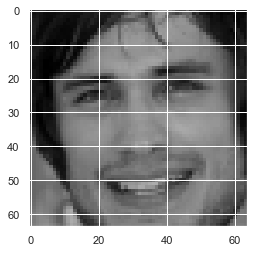

In [316]:
indx = 6
image_0 = X_test[indx][:]
#image_0 = np.reshape(image_0, (64, 64,3))
#image_0 = resize(image_0, (128, 128), anti_aliasing=True)
plt.imshow(image_0,  cmap=plt.cm.gray )

In [299]:
# interprete results
explanation = explainer.explain_instance(X_test[0], model_deep.predict, top_labels=5, hide_color=1, num_samples=1000)


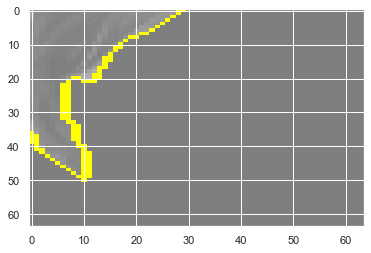

In [300]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), interpolation="nearest", aspect="auto")


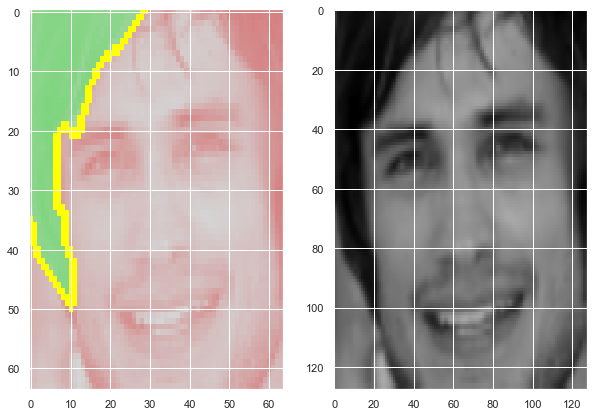

In [301]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

f, axarr = plt.subplots(1,2,figsize=(10, 7))
axarr[0].imshow(mark_boundaries(temp / 2 + 0.5, mask), interpolation="nearest", aspect="auto")
axarr[1].imshow(image_0, interpolation="nearest", aspect="auto")
  
